# 为什么 `pred = u + g*(t - u)` 需要 Norm Rescaling？

## 背景回顾

在 Stable Diffusion 的 Classifier-Free Guidance (CFG) 中，标准公式为：

$$\text{pred} = u + g \cdot (t - u)$$

其中：
- $u$ = unconditional prediction（无条件预测）
- $t$ = conditional prediction（条件预测，给定文本提示）
- $g$ = guidance scale（引导强度，通常 7~15）
- $(t - u)$ = guidance direction（引导方向）

改进后的 rescaled 公式为：

$$\text{pred} = u + g \cdot \frac{(t - u)}{\|t - u\|} \cdot \|u\|$$

## 这个 rescaling 到底在做什么？

把 guidance 项拆开看：

| | 标准 CFG | Rescaled CFG |
|---|---|---|
| guidance 项 | $g \cdot (t - u)$ | $g \cdot \frac{(t-u)}{\|t-u\|} \cdot \|u\|$ |
| guidance 幅度 | $g \cdot \|t - u\|$ | $g \cdot \|u\|$ |
| guidance 方向 | $\frac{t-u}{\|t-u\|}$ (相同) | $\frac{t-u}{\|t-u\|}$ (相同) |

**关键区别**：
- 标准 CFG 的 guidance 幅度 = $g \times \|t - u\|$，**取决于 $\|t-u\|$**
- Rescaled CFG 的 guidance 幅度 = $g \times \|u\|$，**只取决于 $\|u\|$**

所以 rescaling 的真正作用不是简单地"缩小 norm"，而是：**让 guidance 步长与 $\|u\|$ 成比例，与 $\|t-u\|$ 无关，使 $g$ 成为一个更稳定、可预测的旋钮。**

## 为什么这很重要？

在扩散模型的去噪过程中，每一步的 $\|t - u\|$ 是**不稳定的**：
- 不同的 timestep，$\|t - u\|$ 差异很大
- 不同的 prompt，$\|t - u\|$ 差异很大（"a photo of a cat" vs "a surrealist painting of an interdimensional portal"）

标准 CFG 下，**同一个 $g$ 在不同情况下产生的实际 guidance 强度截然不同**。这就像你的油门踏板灵敏度随路况变化——有时候轻踩就飙车，有时候踩到底也没反应。

Rescaled CFG 把 guidance 幅度固定为 $g \times \|u\|$，**让 $g$ 的行为可预测**。

下面用代码来验证这一点。

## 案例 1：标准 CFG 的 guidance 幅度随 ||t-u|| 波动

模拟不同 prompt / timestep 导致 ||t-u|| 不同的场景。

In [7]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# macOS 中文字体配置
mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS 自带，支持中文
mpl.rcParams['axes.unicode_minus'] = False               # 正常显示负号

torch.manual_seed(42)

g = 7.5
dim = 1000  # 简化的高维向量

# u 的 norm 相对稳定（都是噪声预测，量级相似）
u = torch.randn(dim)
norm_u = torch.norm(u)

# 模拟 3 种不同的 (t-u)：norm 差异很大
# 对应不同的 prompt 或不同的 timestep
scenarios = {
    "弱 guidance\n(简单 prompt)":    torch.randn(dim) * 0.3,   # ||t-u|| 很小
    "中等 guidance\n(普通 prompt)":   torch.randn(dim) * 1.0,   # ||t-u|| 中等
    "强 guidance\n(复杂 prompt)":     torch.randn(dim) * 3.0,   # ||t-u|| 很大
}

print(f"||u|| = {norm_u:.2f}\n")
print(f"{'场景':<25} {'||t-u||':>8} {'标准CFG幅度':>12} {'Rescaled幅度':>14}")
print("-" * 65)

std_magnitudes = []
rsc_magnitudes = []
labels = []

for name, diff in scenarios.items():
    norm_diff = torch.norm(diff)
    std_mag = g * norm_diff      # 标准 CFG guidance 幅度
    rsc_mag = g * norm_u         # rescaled CFG guidance 幅度（始终相同！）
    
    std_magnitudes.append(std_mag.item())
    rsc_magnitudes.append(rsc_mag.item())
    labels.append(name)
    
    print(f"{name:<25} {norm_diff:>8.2f} {std_mag:>12.2f} {rsc_mag:>14.2f}")

print(f"\n标准 CFG: guidance 幅度变化范围 = {min(std_magnitudes):.1f} ~ {max(std_magnitudes):.1f} (差 {max(std_magnitudes)/min(std_magnitudes):.1f} 倍!)")
print(f"Rescaled: guidance 幅度始终为  = {rsc_magnitudes[0]:.1f} (恒定!)")

||u|| = 31.72

场景                         ||t-u||      标准CFG幅度     Rescaled幅度
-----------------------------------------------------------------
弱 guidance
(简单 prompt)        9.79        73.41         237.87
中等 guidance
(普通 prompt)      31.53       236.45         237.87
强 guidance
(复杂 prompt)       91.99       689.92         237.87

标准 CFG: guidance 幅度变化范围 = 73.4 ~ 689.9 (差 9.4 倍!)
Rescaled: guidance 幅度始终为  = 237.9 (恒定!)


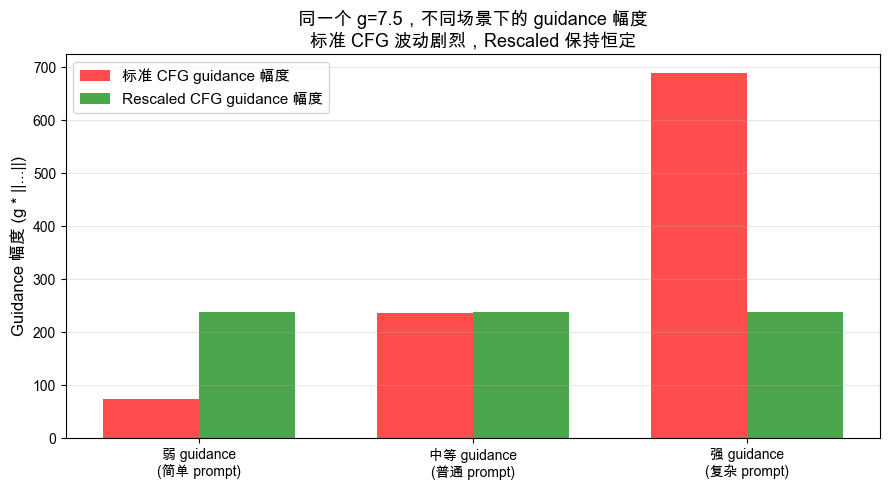

In [8]:
# 可视化：标准 CFG 的 guidance 幅度 vs rescaled
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(labels))
width = 0.35

bars1 = ax.bar(x - width/2, std_magnitudes, width, label='标准 CFG guidance 幅度', color='red', alpha=0.7)
bars2 = ax.bar(x + width/2, rsc_magnitudes, width, label='Rescaled CFG guidance 幅度', color='green', alpha=0.7)

ax.set_ylabel('Guidance 幅度 (g * ||...||)', fontsize=12)
ax.set_title(f'同一个 g={g}，不同场景下的 guidance 幅度\n标准 CFG 波动剧烈，Rescaled 保持恒定', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 案例 2：用 2D 向量直观展示两种情况

**情况 A**：$\|t - u\|$ 很大（标准 CFG 的 guidance 步子太大，rescaled 拉回来）

**情况 B**：$\|t - u\|$ 很小（标准 CFG 的 guidance 几乎没效果，rescaled 补上去）

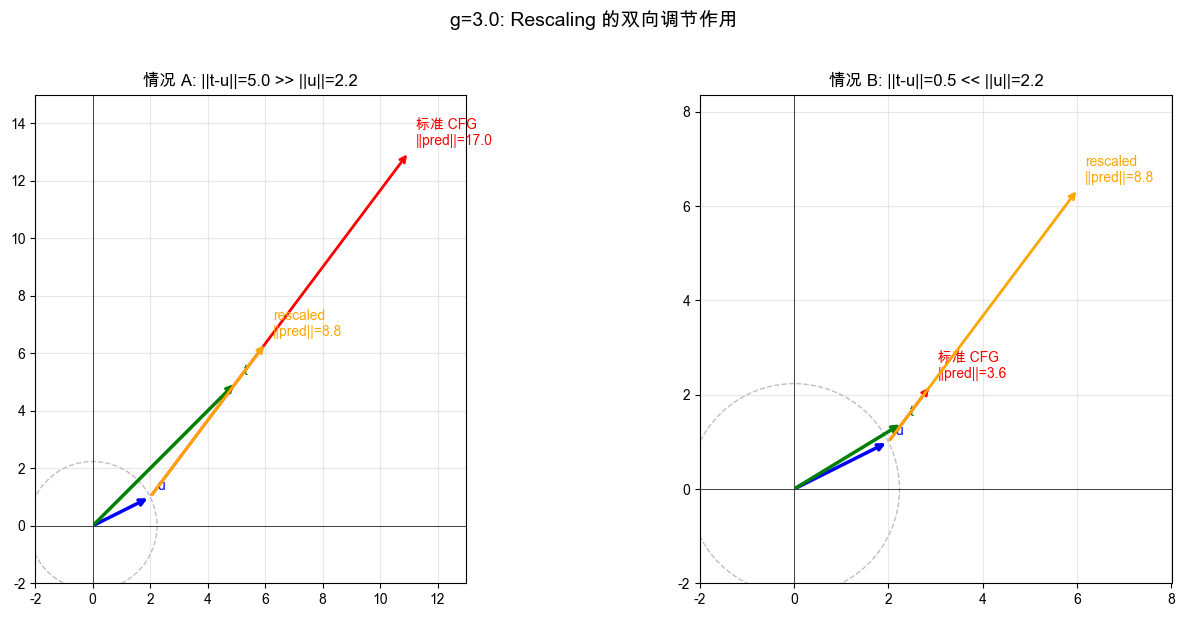

情况 A: ||t-u|| 大 → 标准 CFG 过冲严重 → rescaled 把步长拉回来
情况 B: ||t-u|| 小 → 标准 CFG 几乎没效果 → rescaled 把步长补上去

→ Rescaling 让 guidance 的 '实际力度' 在不同情况下保持一致!


In [9]:
def draw_arrow(ax, start, vec, color, label, lw=2.5):
    """从 start 画一个箭头到 start+vec"""
    end = start + vec
    ax.annotate('', xy=end.tolist(), xytext=start.tolist(),
                arrowprops=dict(arrowstyle='->', color=color, lw=lw))
    ax.annotate(label, xy=end.tolist(), fontsize=10, color=color, 
                fontweight='bold', xytext=(5, 5), textcoords='offset points')

g = 3.0  # 用较小的 g 让图不至于太极端

# 两种场景，u 相同
u = torch.tensor([2.0, 1.0])
norm_u = torch.norm(u)

# 情况 A: ||t-u|| 很大 (强 prompt)
diff_A = torch.tensor([3.0, 4.0])   # ||diff|| = 5.0, 远大于 ||u||=2.24
t_A = u + diff_A

# 情况 B: ||t-u|| 很小 (弱 prompt)
diff_B = torch.tensor([0.3, 0.4])   # ||diff|| = 0.5, 远小于 ||u||=2.24
t_B = u + diff_B

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, diff, t_val, title in [
    (axes[0], diff_A, t_A, f"情况 A: ||t-u||={torch.norm(diff_A):.1f} >> ||u||={norm_u:.1f}"),
    (axes[1], diff_B, t_B, f"情况 B: ||t-u||={torch.norm(diff_B):.1f} << ||u||={norm_u:.1f}"),
]:
    pred_std = u + g * diff
    pred_rsc = u + g * diff / torch.norm(diff) * norm_u
    
    origin = torch.tensor([0.0, 0.0])
    
    # 画 u 和 t
    draw_arrow(ax, origin, u, 'blue', f'u')
    draw_arrow(ax, origin, t_val, 'green', f't')
    
    # 画 guidance 项（从 u 出发）
    draw_arrow(ax, u, g * diff, 'red', 
               f'标准 CFG\n||pred||={torch.norm(pred_std):.1f}', lw=2)
    draw_arrow(ax, u, g * diff / torch.norm(diff) * norm_u, 'orange',
               f'rescaled\n||pred||={torch.norm(pred_rsc):.1f}', lw=2)
    
    # 画 ||u|| 圆
    circle = plt.Circle((0, 0), norm_u.item(), fill=False, 
                         linestyle='--', color='gray', alpha=0.5)
    ax.add_patch(circle)
    
    # 设置
    all_pts = torch.stack([u, t_val, pred_std, pred_rsc, origin])
    margin = 2
    ax.set_xlim(all_pts[:, 0].min().item() - margin, all_pts[:, 0].max().item() + margin)
    ax.set_ylim(all_pts[:, 1].min().item() - margin, all_pts[:, 1].max().item() + margin)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.axvline(x=0, color='k', linewidth=0.5)
    ax.set_title(title, fontsize=12)

plt.suptitle(f'g={g}: Rescaling 的双向调节作用', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("情况 A: ||t-u|| 大 → 标准 CFG 过冲严重 → rescaled 把步长拉回来")
print("情况 B: ||t-u|| 小 → 标准 CFG 几乎没效果 → rescaled 把步长补上去")
print("\n→ Rescaling 让 guidance 的 '实际力度' 在不同情况下保持一致!")

## 案例 3：模拟去噪过程中 ||t-u|| 的波动

在真实的扩散模型去噪过程中，不同 timestep 的 $\|t - u\|$ 差异巨大。我们模拟 50 步去噪，看标准 CFG 和 rescaled CFG 的 guidance 幅度如何变化。

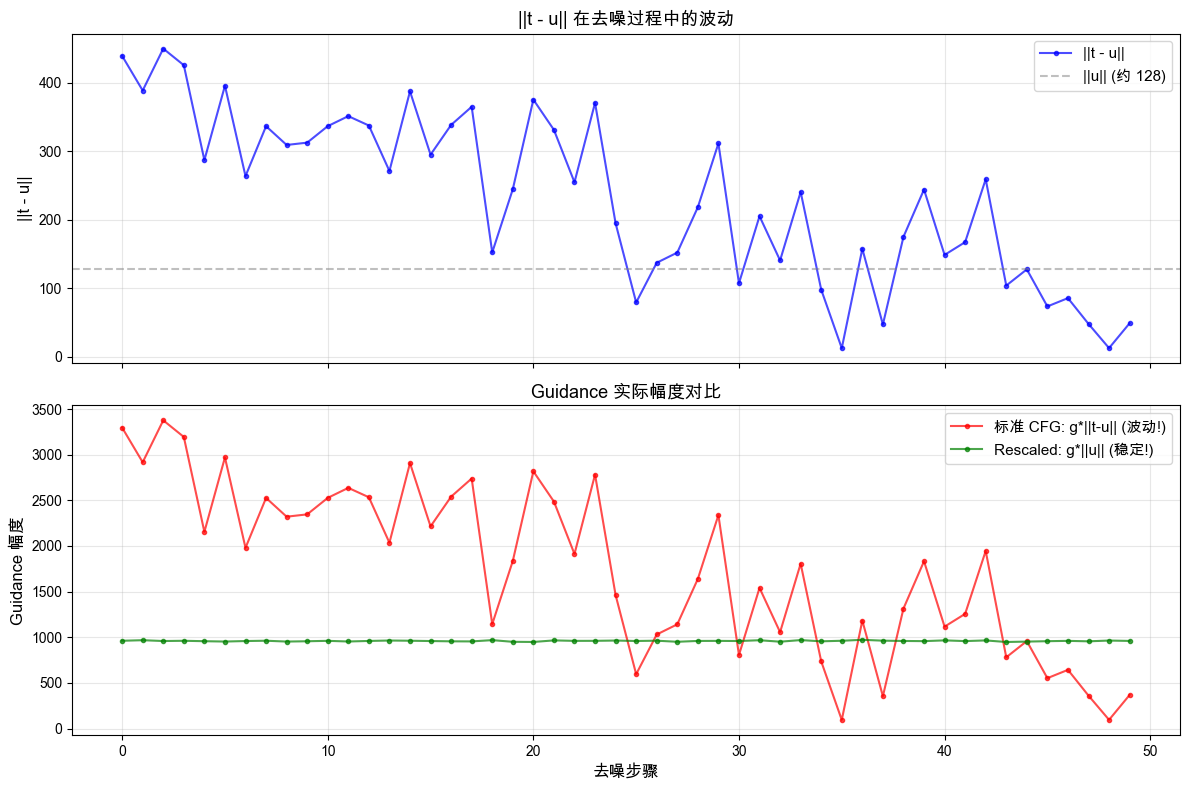

标准 CFG guidance 幅度的变异系数 (CV) = 0.523
Rescaled guidance 幅度的变异系数 (CV) = 0.006

标准 CFG 的波动程度是 rescaled 的 94 倍!


In [10]:
torch.manual_seed(123)

g = 7.5
dim = 4 * 64 * 64  # 真实 latent 维度
n_steps = 50

# 模拟每一步的 u 和 (t-u)
# u 的 norm 相对稳定，但 (t-u) 的 norm 随 timestep 变化很大
# 早期 timestep (噪声大) → ||t-u|| 大；后期 (噪声小) → ||t-u|| 小
steps = list(range(n_steps))
std_guidance_mags = []
rsc_guidance_mags = []
diff_norms = []

for step in steps:
    u_step = torch.randn(dim)  # u 的 norm ≈ sqrt(dim) ≈ 128
    
    # 模拟 ||t-u|| 随 step 变化：早期大，后期小，中间有波动
    scale = 3.0 * (1 - step / n_steps) + 0.2 + 0.5 * torch.randn(1).item()
    scale = max(scale, 0.1)
    diff = torch.randn(dim) * scale
    
    norm_u = torch.norm(u_step)
    norm_diff = torch.norm(diff)
    
    std_guidance_mags.append((g * norm_diff).item())
    rsc_guidance_mags.append((g * norm_u).item())
    diff_norms.append(norm_diff.item())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 上图: ||t-u|| 随步骤的变化
ax1.plot(steps, diff_norms, 'b.-', alpha=0.7, label='||t - u||')
ax1.axhline(y=np.mean([torch.norm(torch.randn(dim)).item() for _ in range(5)]), 
            color='gray', linestyle='--', alpha=0.5, label='||u|| (约 128)')
ax1.set_ylabel('||t - u||', fontsize=12)
ax1.set_title('||t - u|| 在去噪过程中的波动', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 下图: guidance 幅度对比
ax2.plot(steps, std_guidance_mags, 'r.-', alpha=0.7, label='标准 CFG: g*||t-u|| (波动!)')
ax2.plot(steps, rsc_guidance_mags, 'g.-', alpha=0.7, label='Rescaled: g*||u|| (稳定!)')
ax2.set_xlabel('去噪步骤', fontsize=12)
ax2.set_ylabel('Guidance 幅度', fontsize=12)
ax2.set_title('Guidance 实际幅度对比', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

std_cv = np.std(std_guidance_mags) / np.mean(std_guidance_mags)
rsc_cv = np.std(rsc_guidance_mags) / np.mean(rsc_guidance_mags)
print(f"标准 CFG guidance 幅度的变异系数 (CV) = {std_cv:.3f}")
print(f"Rescaled guidance 幅度的变异系数 (CV) = {rsc_cv:.3f}")
print(f"\n标准 CFG 的波动程度是 rescaled 的 {std_cv/rsc_cv:.0f} 倍!")

## 案例 4：模拟 "图像" 效果 — ||t-u|| 很大时标准 CFG 的过饱和

当 prompt 效果很强 ($\|t-u\|$ 很大) 时，标准 CFG 会严重过饱和，rescaled 版本则稳定得多。

||u||     = 27.78
||t-u||   = 111.02  (是 ||u|| 的 4.0 倍!)
||std||   = 833.55  (是 ||u|| 的 30.0 倍)
||rsc||   = 210.59  (是 ||u|| 的 7.6 倍)


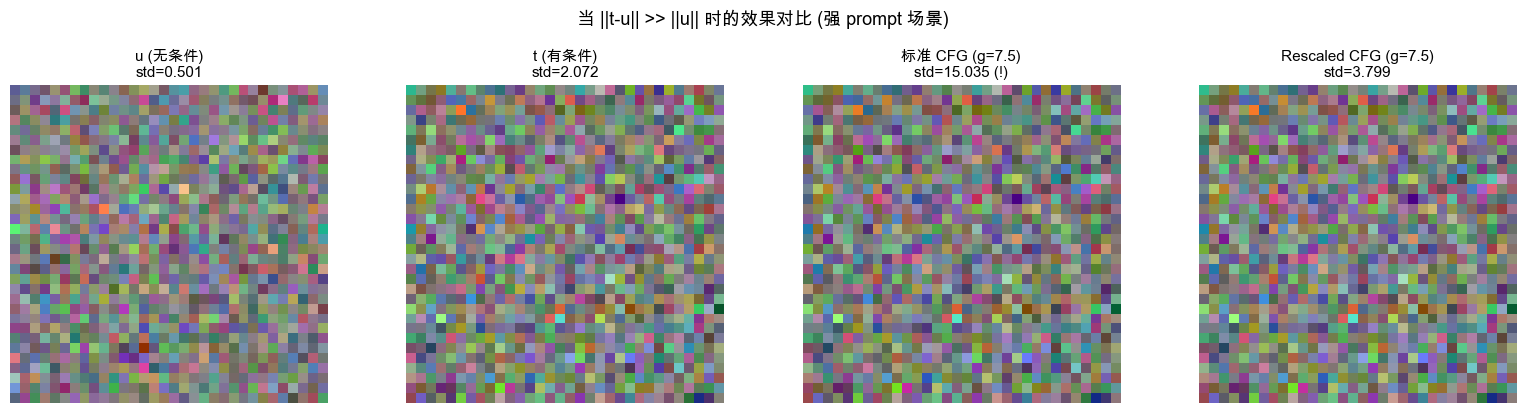


标准 CFG: std 从 0.501 膨胀到 15.035 (30倍!)
Rescaled: std 从 0.501 变为   3.799 (7.6倍)

这就是为什么高 guidance + 强 prompt 会导致过饱和，而 rescaling 能缓解


In [11]:
torch.manual_seed(0)

shape = (3, 32, 32)
g = 7.5

# 无条件预测：正常范围
u_img = torch.randn(shape) * 0.5

# 条件预测偏差很大：模拟 "强 prompt"，||t-u|| >> ||u||
diff_img = torch.randn(shape) * 2.0  # 差值很大
t_img = u_img + diff_img

pred_std = u_img + g * diff_img
pred_rsc = u_img + g * diff_img / torch.norm(diff_img) * torch.norm(u_img)

print(f"||u||     = {torch.norm(u_img):.2f}")
print(f"||t-u||   = {torch.norm(diff_img):.2f}  (是 ||u|| 的 {torch.norm(diff_img)/torch.norm(u_img):.1f} 倍!)")
print(f"||std||   = {torch.norm(pred_std):.2f}  (是 ||u|| 的 {torch.norm(pred_std)/torch.norm(u_img):.1f} 倍)")
print(f"||rsc||   = {torch.norm(pred_rsc):.2f}  (是 ||u|| 的 {torch.norm(pred_rsc)/torch.norm(u_img):.1f} 倍)")

def to_vis(x):
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x.permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles_imgs = [
    ('u (无条件)', u_img, f'std={u_img.std():.3f}'),
    ('t (有条件)', t_img, f'std={t_img.std():.3f}'),
    (f'标准 CFG (g={g})', pred_std, f'std={pred_std.std():.3f} (!)'),
    (f'Rescaled CFG (g={g})', pred_rsc, f'std={pred_rsc.std():.3f}'),
]

for ax, (title, img, info) in zip(axes, titles_imgs):
    ax.imshow(to_vis(img))
    ax.set_title(f'{title}\n{info}', fontsize=11)
    ax.axis('off')

plt.suptitle('当 ||t-u|| >> ||u|| 时的效果对比 (强 prompt 场景)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n标准 CFG: std 从 {u_img.std():.3f} 膨胀到 {pred_std.std():.3f} ({pred_std.std()/u_img.std():.0f}倍!)")
print(f"Rescaled: std 从 {u_img.std():.3f} 变为   {pred_rsc.std():.3f} ({pred_rsc.std()/u_img.std():.1f}倍)")
print(f"\n这就是为什么高 guidance + 强 prompt 会导致过饱和，而 rescaling 能缓解")

## 总结

```python
# 标准 CFG
pred = u + g * (t - u)
# guidance 幅度 = g * ||t - u||  ← 取决于 ||t-u||，不可控

# Norm-Rescaled CFG
pred = u + g * (t - u) / torch.norm(t - u) * torch.norm(u)
# guidance 幅度 = g * ||u||      ← 只取决于 ||u||，稳定可控
```

**Rescaling 的核心作用：将 guidance 步长归一化为与 $\|u\|$ 成比例**

| 场景 | 标准 CFG | Rescaled CFG |
|------|---------|-------------|
| $\|t-u\|$ 很大 (强 prompt) | guidance 过猛 → 过饱和/伪影 | 拉回到合理范围 |
| $\|t-u\|$ 很小 (弱 prompt) | guidance 太弱 → prompt 不生效 | 补偿到合理强度 |
| 不同 timestep | guidance 幅度剧烈波动 | guidance 幅度稳定 |
| $g$ 的含义 | 不确定（受 $\|t-u\|$ 影响） | 确定（始终是 $\|u\|$ 的倍数） |

**一句话总结**：标准 CFG 的 $g$ 像一个"灵敏度不确定的油门"——路况好时一脚油门就飙车，路况差时踩到底也不动。Rescaling 让每一脚油门的力度都一样，使 $g$ 成为真正可靠的控制旋钮。